# With sWeights: `common_B0toDstDs_Dst_constrHEP`
# Without sWeights: `common_Dst_constrHEP`
# Fit the complete data (With sWeights and without sWeights)
- Fit to $m(B^0_s)$ with $m(3\pi)$ around $m(D_s)$ and sWeights
    - Signal $B^0 \to D^{*-} \pi^+ \pi^+ \pi^-$ (gaussian)
    - Background of partially reconstructed decays (gaussian)
    - Combinatorial background (exponential)
- Fit to $m(B^0_s)$ with:
    - Signal $B^0 \to D^{*-} \pi^+ \pi^+ \pi^-$ (sum of two Crystall ball PDF)
        - **FINAL CHOICE: $\alpha_L$, $\alpha_R$, $n_L$ free, $n_R$ fixed**
    - Background $B^0 \to D^{*-} D_s^+$ from the other fit of the simultaneous fit
    - Background with a misidentified pion: $B^0 \to D^{*-} K^+ \pi^+ \pi^-$ (sum of two crystall ball PDF)
    - Combinatorial background (exponential)

- Computation of $\frac{n_{B^0\to D^*D_s}}{n_{B^0\to D^*3\pi}}$ and comparison with the ratio of PDG branching ratio
- Computation of $\frac{n_{B^0\to D^*K \pi \pi}}{n_{B^0\to D^* \pi \pi \pi}}$ and comparison with the ratio of PDG branching ratio. Computation of the rate of misidentified $K$ as $\pi$

Those two fits are not simultaneous. The sWeights are computed in `compute_sWeights_commonHEP.ipynb` with the `hepstats` library

In [1]:
name_data_MC = 'MC_constr_opposedCB_sharedMean'
name_data_KPiPi = "data_KPiPi_constr"
name_BDT = 'gradient_bkgHighB0M'

name_dataHEP = 'common_Dst_constrHEP'
name_data_B0toDstDsHEP = 'common_B0toDstDs_Dst_constrHEP'
name_data_Dstto3piHEP = 'common_Dstto3piHEP'

## Import

In [2]:
import zfit
import timeit
import pandas as pd


from bd2dst3pi.locations import loc
from bd2dst3pi.definitions import years, magnets

import sys
sys.path.append(loc.SCRIPTS)
from load_save_data import load_data, load_saved_root, add_constr_Dst, json_to_latex_table, retrieve_params, save_dataframe
from plot.fit import plot_hist_fit_particle
import plot.histogram as h
from fit import launch_fit, define_zparams, save_params, sum_crystalball
from variables import name_params, name_params_B0toDstDs
from plot.tool import fix_plot, save_file

Welcome to JupyROOT 6.22/02


## Load

In [3]:
df = load_data(years, magnets, type_data='common', vars=['B0_M','tau_M', 'Dst_M'],
                            cut_DeltaM=True)
# df = load_saved_root('common_'+name_BDT, name_folder='common')

/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//common/data/data_90000000_2015_up.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//common/data/data_90000000_2015_down.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//common/data/data_90000000_2016_up.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//common/data/data_90000000_2016_down.root
cut on DeltaM has removed 425088 over 935261 events


Constrained data

In [4]:
df = add_constr_Dst(df)
var = 'Dst_constr_B0_M'

## Fit to weighted `B0_M` with `|tau_M-1969|<50`

### Data

In [5]:
size_tau_M = 50.
mean_tau_M = 1969.
low_tau_M = mean_tau_M - size_tau_M
high_tau_M = mean_tau_M + size_tau_M

df_Ds = df.query(f"abs(tau_M-{mean_tau_M})<={size_tau_M}")

In [6]:
low_B0Ds = 5150.
high_B0Ds = 5360.
weightsHEP = load_saved_root(name_data_Dstto3piHEP, ['sWeight'], name_folder='common')['sWeight']

/afs/cern.ch/user/c/correian/bd2dst3pi/output//root/common/common_Dstto3piHEP.root


### Distribution

/afs/cern.ch/user/c/correian/bd2dst3pi/scripts/plot/histogram.py:65: RuntimeWarning: invalid value encountered in sqrt
  err = np.sqrt(counts)


/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/B0_M_common_B0toDstDs_Dst_constrHEP


/afs/cern.ch/user/c/correian/bd2dst3pi/scripts/plot/histogram.py:65: RuntimeWarning: invalid value encountered in sqrt
  err = np.sqrt(counts)


/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/Dst_constr_B0_M_common_B0toDstDs_Dst_constrHEP


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='$m$($D^*3\\pi|m(D_s)$=2010.26 MeV/$c^2$) [MeV/$c^2$]', ylabel='Candidates / (2 MeV/$c^2$)'>)

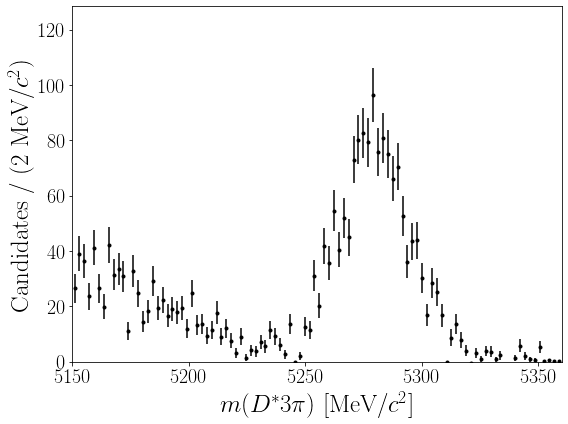

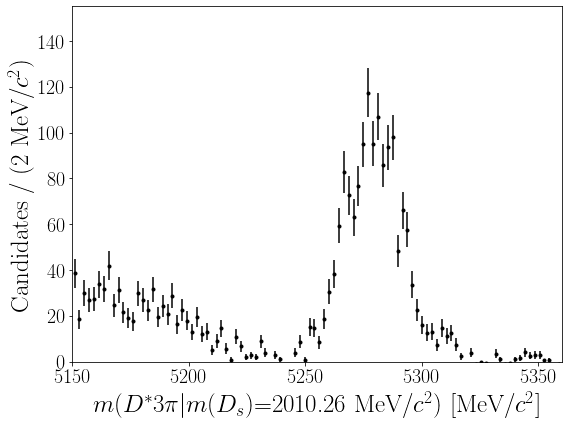

In [7]:
h.plot_hist_particle({name_data_B0toDstDsHEP:df_Ds},'B0_M',
              low = low_B0Ds, high = high_B0Ds,
              n_bins = 100, mode_hist = False, colors='black', weights=weightsHEP)
h.plot_hist_particle({name_data_B0toDstDsHEP:df_Ds}, var,
              low = low_B0Ds, high = high_B0Ds,
              n_bins = 100, mode_hist = False, colors='black', weights=weightsHEP)


### Starting values

In [8]:
n_events_B0Ds = len(df_Ds.query(f'B0_M > {low_B0Ds} and B0_M < {high_B0Ds}'))

n_sig_k = 1600
n_bkg_k = 300
n_bkg2_k = 700

initial_values_B0Ds = {
    # Signal
    'mu_B0Ds'       :{ 'value': 5280.                         , 'low': 5280.-4.       , 'high': 5280.+4.             , 'floating': True},
    'sigma_B0Ds'    :{ 'value': 15.                           , 'low': 15.-5.        , 'high': 15.+5.                , 'floating': True},
    'n_sig_B0Ds'    :{ 'value': n_sig_k                       , 'low': 0              , 'high': n_events_B0Ds        , 'floating': True},
    # Combinatorial background
    'lambda_B0Ds'   :{ 'value': -0.005                       , 'low': -0.1           , 'high': -0.00000000000000001 , 'floating': True},
    'n_bkg_B0Ds'    :{ 'value': n_bkg_k                       , 'low': 0              , 'high': n_events_B0Ds        , 'floating': True},
    # Partially reconstructed particles
    'mu2_B0Ds'      :{ 'value': 5150                          , 'low': 4800.          , 'high': 5200.                , 'floating': True},
    'sigma2_B0Ds'   :{ 'value': 40.                           , 'low': 10.            , 'high': 90.                  , 'floating': True},
    'n_bkg2_B0Ds'   :{ 'value': n_bkg2_k                      , 'low': 0              , 'high': n_events_B0Ds        , 'floating': True},
}

### Observables and variables

In [9]:
obs_B0Ds = zfit.Space("x", limits=(low_B0Ds, high_B0Ds))

zparams_B0Ds = define_zparams(initial_values_B0Ds)

### PDFs

In [11]:
gaussianS_B0Ds = zfit.pdf.Gauss(zparams_B0Ds['mu_B0Ds'],zparams_B0Ds['sigma_B0Ds'],obs=obs_B0Ds)
exponential_B0Ds = zfit.pdf.Exponential(zparams_B0Ds['lambda_B0Ds'], obs=obs_B0Ds)
gaussian_B0Ds = zfit.pdf.Gauss(zparams_B0Ds['mu2_B0Ds'],zparams_B0Ds['sigma2_B0Ds'],obs=obs_B0Ds)

gaussianS_B0Ds_ext = gaussianS_B0Ds.create_extended(zparams_B0Ds['n_sig_B0Ds'])
exponential_B0Ds_ext = exponential_B0Ds.create_extended(zparams_B0Ds['n_bkg_B0Ds'])
gaussian_B0Ds_ext = gaussian_B0Ds.create_extended(zparams_B0Ds['n_bkg2_B0Ds'])

model_B0Ds = zfit.pdf.SumPDF([gaussianS_B0Ds_ext, exponential_B0Ds_ext, gaussian_B0Ds_ext])
data_B0DsHEP = zfit.Data.from_pandas(df_Ds[var], obs=obs_B0Ds, weights=weightsHEP)

### Fitting

In [12]:
start = timeit.default_timer()
result_B0Ds, params_B0Ds = launch_fit(model_B0Ds, data_B0DsHEP, extended=True)
result_B0Ds, params_B0Ds = launch_fit(model_B0Ds, data_B0DsHEP, extended=True)
result_B0Ds, params_B0Ds = launch_fit(model_B0Ds, data_B0DsHEP, extended=True)
stop = timeit.default_timer()
print('Time to do the fit: ', stop - start) 


------------------------------------------------------------------
| FCN = -4518                   |     Ncalls=340 (340 total)     |
| EDM = 9.6e-05 (Goal: 0.001)   |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------


/afs/cern.ch/work/c/correian/miniconda/envs/bd2dst3pi_env/lib/python3.7/site-packages/zfit/minimizers/fitresult.py:46: ExperimentalFeatureWarning: The computation of the covariance matrix with weights is still experimental.
  ExperimentalFeatureWarning)


name              value    minuit_hesse    at limit
-----------  ----------  --------------  ----------
n_sig_B0Ds         1479     +/-      40       False
n_bkg_B0Ds        64.58     +/-      53       False
n_bkg2_B0Ds       726.9     +/-      39       False
mu_B0Ds            5279     +/-    0.52       False
sigma_B0Ds        12.47     +/-    0.46       False
lambda_B0Ds  -7.596e-08     +/- 3.7e-06       False
mu2_B0Ds           5167     +/-     3.6       False
sigma2_B0Ds       28.26     +/-     2.7       False
------------------------------------------------------------------
| FCN = -4518                   |     Ncalls=112 (112 total)     |
| EDM = 8.52e-06 (Goal: 0.001)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
-----------

### Plotting and saving

/afs/cern.ch/user/c/correian/bd2dst3pi/scripts/plot/histogram.py:65: RuntimeWarning: invalid value encountered in sqrt
  err = np.sqrt(counts)


Number of d.o.f. in the model:  8
Reduced chi2:  1.7703064416266607
/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/common_Dst_constrHEP/Dst_constr_B0_M_common_B0toDstDs_Dst_constrHEP_details_fit


(<Figure size 864x720 with 2 Axes>,
 <AxesSubplot:xlabel='$m$($D^*3\\pi|m(D_s)$=2010.26 MeV/$c^2$) [MeV/$c^2$]', ylabel='Candidates / (2 MeV/$c^2$)'>,
 <AxesSubplot:xlabel='(reduced $\\chi^2$=1.77)', ylabel='residuals / $\\sigma$'>)

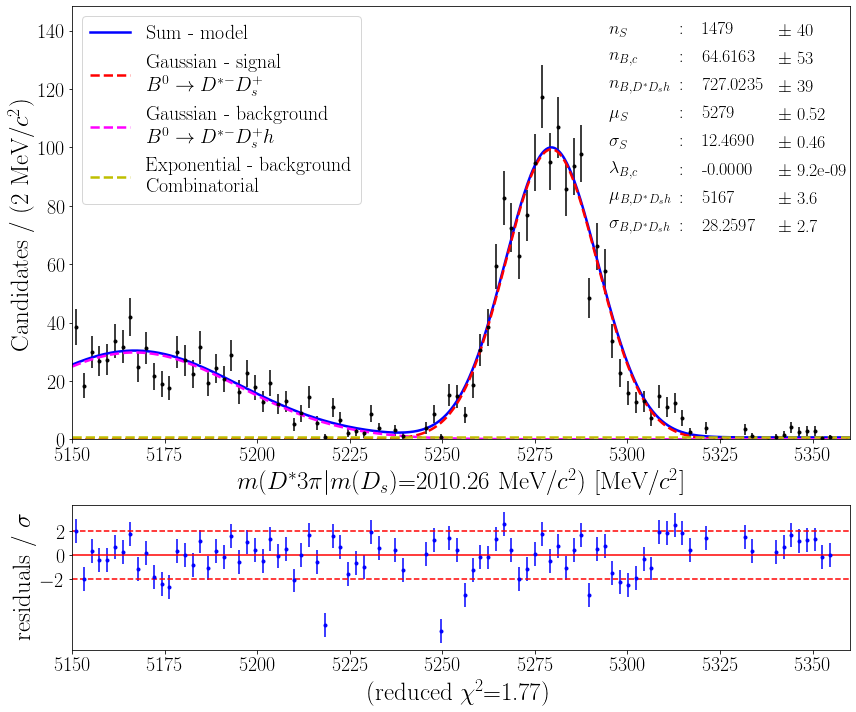

In [15]:
plot_hist_fit_particle(df_Ds, var, models = [model_B0Ds, gaussianS_B0Ds_ext, gaussian_B0Ds_ext, exponential_B0Ds_ext],
                       name_models = ["", '\n $B^0\\to D^{*-}D_s^+$','\n $B^0\\to D^{*-}D_s^+ h$',
                                      '\n Combinatorial'],
                       obs=obs_B0Ds, n_bins = 100,mode_hist = False,
                       name_data=name_data_B0toDstDsHEP+'_details', name_folder=name_dataHEP,
                       colors=['b','r','magenta','y'], weights=weightsHEP,
                       params=params_B0Ds,name_params=name_params_B0toDstDs,
                       colWidths=[0.05,0.01,0.05,0.04], show_chi2=True,
                       fontsize_res = 18.,
                       fontsize_leg=20)

/afs/cern.ch/user/c/correian/bd2dst3pi/scripts/plot/histogram.py:65: RuntimeWarning: invalid value encountered in sqrt
  err = np.sqrt(counts)


Number of d.o.f. in the model:  8
Reduced chi2:  0.4549593325582092
/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/common_Dst_constrHEP/Dst_constr_B0_M_common_B0toDstDs_Dst_constrHEP_50_fit


(<Figure size 864x720 with 2 Axes>,
 <AxesSubplot:xlabel='$m$($D^*3\\pi|m(D_s)$=2010.26 MeV/$c^2$) [MeV/$c^2$]', ylabel='Candidates / (5 MeV/$c^2$)'>,
 <AxesSubplot:ylabel='residuals / $\\sigma$'>)

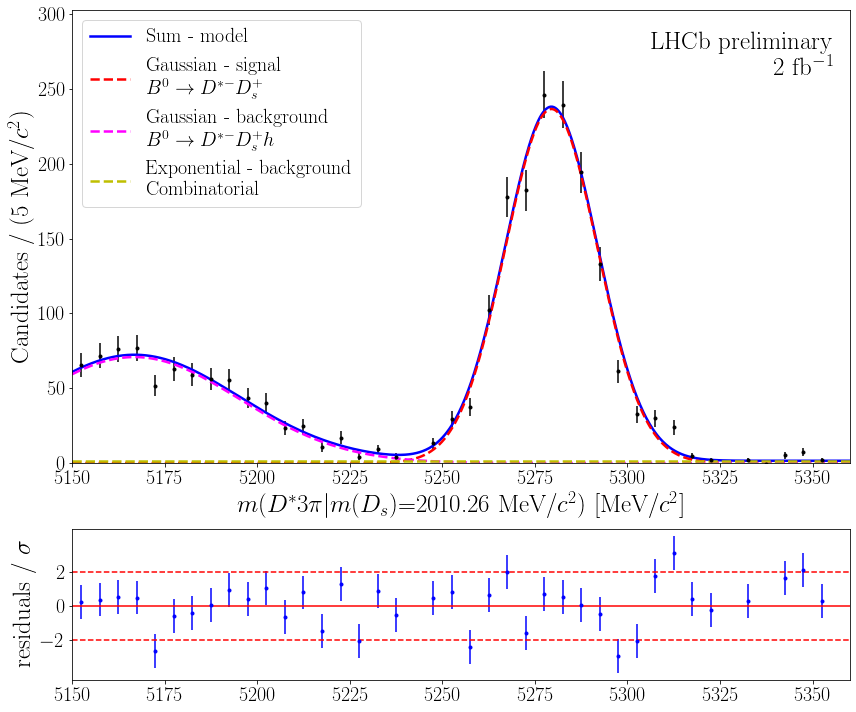

In [19]:
plot_hist_fit_particle(df_Ds,var, models = [model_B0Ds, gaussianS_B0Ds_ext, gaussian_B0Ds_ext, exponential_B0Ds_ext],
                       name_models = ["", '\n $B^0\\to D^{*-}D_s^+$','\n $B^0\\to D^{*-}D_s^+ h$',
                                      '\n Combinatorial'],
                       obs=obs_B0Ds, n_bins = 42, mode_hist = False,
                       name_data = name_data_B0toDstDsHEP+'_50', name_folder=name_dataHEP,
                       colors=['b','r','magenta','y'], weights=weightsHEP,
                       fontsize_res = 18., pos_text_LHC='right',
                       fontsize_leg=20)

In [16]:
save_params(params_B0Ds, name_data_B0toDstDsHEP, True, name_folder=name_data_B0toDstDsHEP)

parameters saved in /afs/cern.ch/user/c/correian/bd2dst3pi/output/json/common_B0toDstDs_Dst_constrHEP/common_B0toDstDs_Dst_constrHEP_params.json


### Latex table

In [18]:
json_to_latex_table(name_data_B0toDstDsHEP, name_data_B0toDstDsHEP, name_params_B0toDstDs)

/afs/cern.ch/user/c/correian/bd2dst3pi/output/tables/common_B0toDstDs_Dst_constrHEP/common_B0toDstDs_Dst_constrHEP_params.tex
\begin{tabular}[t]{lc}
\hline
Variable &Fitted Value\\
\hline\hline
$\lambda_{B,c}$&$-0.002\pm0.011$\\
\hline
$\mu_{B, D^* D_s h}$&$5151\pm11$\\
\hline
$\mu_S$&$5279.73\pm0.66$\\
\hline
$n_{B, D^* D_s h}$&$(7.1\pm1.3)\times 10^2$\\
\hline
$n_{B,c}$&$(1.6\pm1.6)\times 10^2$\\
\hline
$n_S$&$1414\pm53$\\
\hline
$\sigma_{B, D^* D_s h}$&$38.9\pm7.3$\\
\hline
$\sigma_S$&$14.87\pm0.63$\\
\hline
\end{tabular}


In [13]:
fitted_params_Ds = retrieve_params(name_data_B0toDstDsHEP, name_folder=name_data_B0toDstDsHEP)
fitted_params_Ds

{'lambda_B0Ds': -0.0021827378501539513,
 'lambda_B0Ds_err': 0.011030658694821827,
 'mu2_B0Ds': 5151.104554365443,
 'mu2_B0Ds_err': 11.46089507117912,
 'mu_B0Ds': 5279.729345004105,
 'mu_B0Ds_err': 0.6573398325965838,
 'n_bkg2_B0Ds': 714.620211487685,
 'n_bkg2_B0Ds_err': 133.0214793115373,
 'n_bkg_B0Ds': 156.34511011507118,
 'n_bkg_B0Ds_err': 164.9118250417694,
 'n_sig_B0Ds': 1413.7900089161067,
 'n_sig_B0Ds_err': 52.523833927836876,
 'sigma2_B0Ds': 38.855840158248455,
 'sigma2_B0Ds_err': 7.274898973960163,
 'sigma_B0Ds': 14.86620416256119,
 'sigma_B0Ds_err': 0.6313173227371852}

## Fit to the full `B0_M`

In [16]:
low = 5150.
high = 5545.

### Data

In [17]:
data_KPiPi_params = retrieve_params(name_data_KPiPi, name_folder='data_KPiPi') # already in MeV   
data_B0Ds_params = retrieve_params(name_data_B0toDstDsHEP, name_folder=name_data_B0toDstDsHEP)   
MC_param_results = retrieve_params(name_data_MC, name_folder='MC') 

### Distribution

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/Dst_constr_B0_M_common_Dst_constrHEP


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='$m$($D^*3\\pi|m(D_s)$=2010.26 MeV/$c^2$) [MeV/$c^2$]', ylabel='Candidates / (4 MeV/$c^2$)'>)

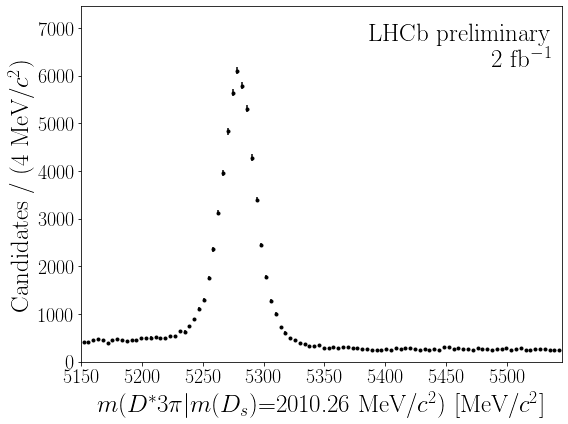

In [18]:
h.plot_hist_particle({name_dataHEP:df}, var,
              low = low, high = high,
              n_bins = 100, mode_hist = False, colors='black', pos_text_LHC='right')

### Initial values

In [19]:
data_B0Ds_params

{'lambda_B0Ds': -0.0021827378501539513,
 'lambda_B0Ds_err': 0.011030658694821827,
 'mu2_B0Ds': 5151.104554365443,
 'mu2_B0Ds_err': 11.46089507117912,
 'mu_B0Ds': 5279.729345004105,
 'mu_B0Ds_err': 0.6573398325965838,
 'n_bkg2_B0Ds': 714.620211487685,
 'n_bkg2_B0Ds_err': 133.0214793115373,
 'n_bkg_B0Ds': 156.34511011507118,
 'n_bkg_B0Ds_err': 164.9118250417694,
 'n_sig_B0Ds': 1413.7900089161067,
 'n_sig_B0Ds_err': 52.523833927836876,
 'sigma2_B0Ds': 38.855840158248455,
 'sigma2_B0Ds_err': 7.274898973960163,
 'sigma_B0Ds': 14.86620416256119,
 'sigma_B0Ds_err': 0.6313173227371852}

In [20]:
n_events_B0_M = len(df.query(f'B0_M > {low} and B0_M < {high}'))


## common_Dst_constr_B0toDstDsWithmu2Free
# n_sig        54130     +/- 9.6e+02       False
# r_bkgK     0.03406     +/-   0.018       False
# n_bkg        27750     +/- 6.3e+02       False
# frac        0.4695     +/-   0.052       False
# alphaL       1.933     +/-    0.14       False
# mu            5279     +/-   0.088       False
# nL          0.5702     +/-    0.13       False
# sigmaL       11.14     +/-     0.5       False
# alphaR      -1.654     +/-    0.51       False
# nR           15.52     +/-      70       False
# sigmaR       18.63     +/-    0.67       False
# lambda  -0.0004345     +/- 0.00016       False
# nR fixed
# n_sig_k = 54000
# n_bkg_k = 27000
# r_bkgK_k = 0.034
# initial_values = {
#     # Signal        
#     'mu'       :{ 'value': 5279.                         , 'low': 5279.-3.       , 'high': 5279.+3.             , 'floating': True},
#     'sigmaL'   :{ 'value': 11.                           , 'low': 5.             , 'high': 15.                  , 'floating': True},
#     'sigmaR'   :{ 'value': 19.                           , 'low': 15.            , 'high': 25.                  , 'floating': True},
#     'alphaL'   :{ 'value': 1.9                           , 'low': 0.1            , 'high': 10.                  , 'floating': True},
#     'alphaR'   :{ 'value': -1.65                         , 'low': -10.           , 'high': -0.1                 , 'floating': True},
#     'nL'       :{ 'value': 0.4                           , 'low': 0.1            , 'high': 10.                  , 'floating': True},
#     'nR'       :{ 'value': 15.5                          , 'low': 1.            , 'high': 200.                  , 'floating': True},
#     'frac'     :{ 'value': 0.47                          , 'low': 0.1            , 'high': 1.                   , 'floating': True},
#     'n_sig'    :{ 'value': n_sig_k                       , 'low': n_sig_k*0.5    , 'high': n_events_B0_M        , 'floating': True},
#     # Combinatorial background        
#     'lambda'   :{ 'value': -0.0004                       , 'low': -0.001         , 'high': -0.000001            , 'floating': True},
#     'n_bkg'    :{ 'value': n_bkg_k                       , 'low': n_bkg_k*0.5    , 'high': n_events_B0_M        , 'floating': True},
#     # Background decay D*Kpipi    
#     'r_bkgK'   :{ 'value': r_bkgK_k                      , 'low': 0.0001          , 'high': 0.08                , 'floating': True},
# }


n_sig_k = 54000
n_bkg_k = 27000
r_bkgK_k = 0.03
initial_values = {
    # Signal        
    'mu'       :{ 'value': 5279.                         , 'low': 5279.-3.       , 'high': 5279.+3.             , 'floating': True},
    'sigmaL'   :{ 'value': 11.                           , 'low': 5.             , 'high': 15.                  , 'floating': True},
    'sigmaR'   :{ 'value': 19.                           , 'low': 15.            , 'high': 25.                  , 'floating': True},
    'alphaL'   :{ 'value': MC_param_results['alphaL_MC'] , 'low': 0.1            , 'high': 10.                  , 'floating': True},
    'alphaR'   :{ 'value': MC_param_results['alphaR_MC'] , 'low': -10.           , 'high': -0.1                 , 'floating': True},
    'nL'       :{ 'value': MC_param_results['nL_MC']     , 'low': 0.1            , 'high': 10.                  , 'floating': True},
    'nR'       :{ 'value': MC_param_results['nR_MC']      , 'low': 1.             , 'high': 70.                 , 'floating': False},
    'frac'     :{ 'value': 0.5                           , 'low': 0.1            , 'high': 1.                   , 'floating': True},
    'n_sig'    :{ 'value': n_sig_k                       , 'low': n_sig_k*0.5    , 'high': n_events_B0_M        , 'floating': True},
    # Combinatorial background        
    'lambda'   :{ 'value': -0.00003                      , 'low': -0.001         , 'high': -0.000001            , 'floating': True},
    'n_bkg'    :{ 'value': n_bkg_k                       , 'low': n_bkg_k*0.5    , 'high': n_events_B0_M        , 'floating': True},
    # Background decay D*Kpipi    
    'r_bkgK'   :{ 'value': r_bkgK_k                      , 'low': 0.0001          , 'high': 0.08                , 'floating': True},
}

for variable in 'muL', 'muR', 'sigmaL', 'sigmaR', 'nL', 'nR', 'alphaL', 'alphaR', 'nL', 'nR', 'fraction':
    initial_values[f'{variable}_K'] = {'value': data_KPiPi_params[variable], 'low': None, 'high': None, 'floating': False}

for variable in 'mu', 'sigma', 'n_sig' :
    initial_values[f'{variable}_DsB0'] = {'value': data_B0Ds_params[f'{variable}_B0Ds'], 'low': None, 'high': None, 'floating': False}

### Observables and variables

In [21]:
obs = zfit.Space("x", limits=(low, high))

zparams = define_zparams(initial_values)

# Composed parameter
mult = lambda r, n: r*n
zparams["n_bkgK"] = zfit.ComposedParameter("n_bkgK", mult, params=[zparams['r_bkgK'],zparams['n_sig']])

### PDFs

In [22]:
model_S, crystalBallL_S, crystalBallR_S = sum_crystalball(zparams['mu'], zparams['mu'],
                                                          zparams['sigmaL'], zparams['sigmaR'],
                                                          zparams['frac'], obs,                                                          
                                                          zparams['alphaL'], zparams['alphaR'], 
                                                          zparams['nL'], zparams['nR']
                                                         )


gaussian_B0Ds = zfit.pdf.Gauss(zparams['mu_DsB0'],zparams['sigma_DsB0'],obs=obs)

model_K, crystalBallL_K, crystalBallR_K = sum_crystalball(zparams['muL_K'], zparams['muR_K'], 
                                                          zparams['sigmaL_K'], zparams['sigmaR_K'],
                                                          zparams['fraction_K'], obs,
                                                          zparams['alphaL_K'], zparams['alphaR_K'], 
                                                          zparams['nL_K'], zparams['nR_K'])

exponential = zfit.pdf.Exponential(zparams['lambda'], obs=obs)


model_S_ext = model_S.create_extended(zparams['n_sig'])
exp_ext = exponential.create_extended(zparams['n_bkg'])
gaussian_B0Ds_ext = gaussian_B0Ds.create_extended(zparams['n_sig_DsB0'])
model_K_ext = model_K.create_extended(zparams['n_bkgK'])

model = zfit.pdf.SumPDF([model_S_ext, gaussian_B0Ds_ext, model_K_ext, exp_ext]) # gauss is folded by frac
data = zfit.Data.from_pandas(df[var], obs=obs)

### Fit

In [23]:
import timeit
start = timeit.default_timer()
result, params = launch_fit(model, data, extended=True)
result, params = launch_fit(model, data, extended=True)
result, params = launch_fit(model, data, extended=True)

stop = timeit.default_timer()
print('Time to do the fit: ', stop - start) 

------------------------------------------------------------------
| FCN = -4.312e+05              |     Ncalls=933 (933 total)     |
| EDM = 0.000442 (Goal: 0.001)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
name         value    minuit_hesse    at limit
------  ----------  --------------  ----------
n_sig        54580     +/- 1.2e+03       False
r_bkgK     0.03476     +/-   0.015       False
n_bkg   

**$\alpha_L$, $\alpha_R$, $n_L$ free**: ok 

**All free**: unstable

Number of d.o.f. in the model:  11
Reduced chi2:  1.2206028822153363
/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/common_Dst_constrHEP/Dst_constr_B0_M_common_Dst_constrHEP_details_fit


(<Figure size 864x720 with 2 Axes>,
 <AxesSubplot:xlabel='$m$($D^*3\\pi|m(D_s)$=2010.26 MeV/$c^2$) [MeV/$c^2$]', ylabel='Candidates / (4 MeV/$c^2$)'>,
 <AxesSubplot:xlabel='(reduced $\\chi^2$=1.22)', ylabel='residuals / $\\sigma$'>)

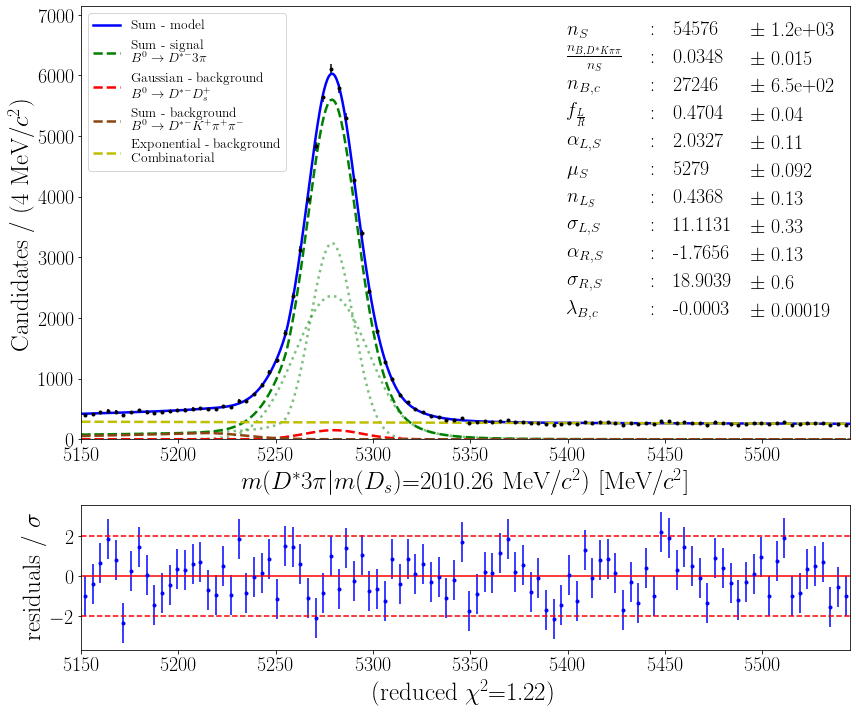

In [30]:
name_data_plot = name_dataHEP + '_details'
plot_hist_fit_particle(df, var, models = [model,[model_S_ext, crystalBallL_S, crystalBallR_S], gaussian_B0Ds_ext, model_K_ext,exp_ext],
                       name_models = ["", '\n $B^0\\to D^{*-} 3\pi$','\n $B^0\\to D^{*-}D_s^+$',
                                      '\n $B^0\\to D^{*-} K^+ \pi^+\pi^-$','\n Combinatorial'],
                       obs=obs, n_bins = 100,mode_hist = False,
                       name_data = name_data_plot, name_folder=name_dataHEP,
                       colors=['b','g','r','saddlebrown','y'],
                        params=params,name_params=name_params,
                       fontsize_leg=13.5, show_chi2=True,
                       colWidths=[0.06,0.01,0.05,0.06], 
                      )


Number of d.o.f. in the model:  11
Reduced chi2:  1.2206028822153363
/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/common_Dst_constrHEP/Dst_constr_B0_M_common_Dst_constrHEP_fit


(<Figure size 864x720 with 2 Axes>,
 <AxesSubplot:xlabel='$m$($D^*3\\pi|m(D_s)$=2010.26 MeV/$c^2$) [MeV/$c^2$]', ylabel='Candidates / (4 MeV/$c^2$)'>,
 <AxesSubplot:ylabel='residuals / $\\sigma$'>)

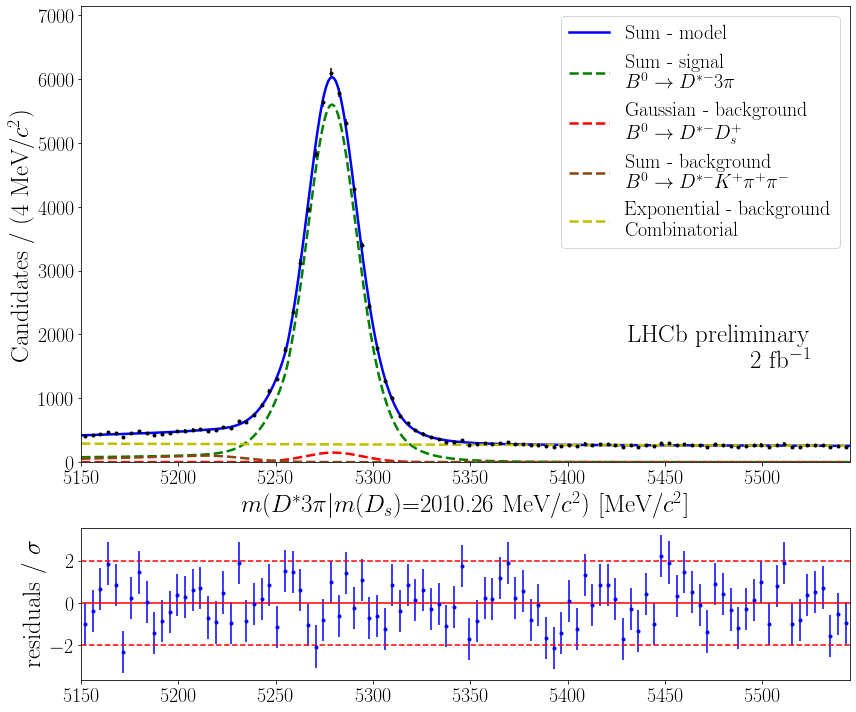

In [31]:
name_data_plot = name_dataHEP
plot_hist_fit_particle(df,var, models = [model, model_S_ext, gaussian_B0Ds_ext, model_K_ext,exp_ext],
                      name_models = ["", '\n $B^0\\to D^{*-} 3\pi$','\n $B^0\\to D^{*-}D_s^+$',
                                      '\n $B^0\\to D^{*-} K^+ \pi^+\pi^-$','\n Combinatorial'],
                       obs=obs, n_bins = 100,mode_hist = False,
                       name_data = name_data_plot, name_folder=name_dataHEP,
                       colors=['b','g','r','saddlebrown','y'], loc_leg='best',
                       fontsize_leg=20., pos_text_LHC=[0.95, 0.30, 'right'],
                      )

In [14]:
save_params(params,name_dataHEP, True, name_folder=name_dataHEP)

parameters saved in /afs/cern.ch/user/c/correian/bd2dst3pi/output/json/common_Dst_constrHEP/common_Dst_constrHEP_params.json


### Latex table

In [15]:
json_to_latex_table(name_dataHEP, name_dataHEP, name_params)

/afs/cern.ch/user/c/correian/bd2dst3pi/output/tables/common_Dst_constrHEP/common_Dst_constrHEP_params.tex
\begin{tabular}[t]{lc}
\hline
Variable &Fitted Value\\
\hline\hline
$\alpha_{L, S}$&$2.03\pm0.11$\\
\hline
$\alpha_{R, S}$&$-1.77\pm0.13$\\
\hline
$f_{\frac{L}{R}}$&$0.470\pm0.040$\\
\hline
$\lambda_{B,c}$&$-0.00032\pm0.00019$\\
\hline
$\mu_S$&$5278.900\pm0.092$\\
\hline
$n_{L_S}$&$0.44\pm0.13$\\
\hline
$n_{B,c}$&$(2.725\pm0.065)\times 10^4$\\
\hline
$n_S$&$(5.46\pm0.12)\times 10^4$\\
\hline
$\frac{n_{B,D^*K\pi\pi}}{n_S}$&$0.035\pm0.015$\\
\hline
$\sigma_{L, S}$&$11.11\pm0.33$\\
\hline
$\sigma_{R, S}$&$18.90\pm0.61$\\
\hline
\end{tabular}


In [16]:
fitted_params = retrieve_params(name_dataHEP, name_folder=name_dataHEP)

In [17]:
fitted_params

{'alphaL': 2.033236156537412,
 'alphaL_err': 0.10811892347545604,
 'alphaR': -1.7661164319326446,
 'alphaR_err': 0.12613877170369692,
 'frac': 0.47021665759394515,
 'frac_err': 0.04041873773542381,
 'lambda': -0.00031530633140561064,
 'lambda_err': 0.00018674057021720068,
 'mu': 5278.9001545132705,
 'mu_err': 0.09162907067112346,
 'nL': 0.4366985512114718,
 'nL_err': 0.13304237519522985,
 'n_bkg': 27248.095520198513,
 'n_bkg_err': 654.1584449640179,
 'n_sig': 54571.35670100774,
 'n_sig_err': 1230.2663228649958,
 'r_bkgK': 0.0347974418289691,
 'r_bkgK_err': 0.015311718614009403,
 'sigmaL': 11.111050402214012,
 'sigmaL_err': 0.33450919573692756,
 'sigmaR': 18.903210285557556,
 'sigmaR_err': 0.6053190234608756}

### Compute the misidentified $K$ rate

$$\mathcal{B}\left(B^0 \to D^{*-} \pi^+ \pi^- \pi^-\right) = (7.21 \pm 0.29)\times 10^{-3}$$
$$\mathcal{B}\left(B^0 \to D^{*-} K^+ \pi^- \pi^-\right) = (4.7 \pm 0.4)\times 10^{-4}$$


In [18]:
from uncertainties import ufloat

### $\frac{\mathcal{B}(B^0\to D^*K \pi \pi)}{\mathcal{B}(B^0\to D^* \pi \pi \pi)}$, from the fit

In [19]:
normal_mode_br = ufloat(7.21e-3, 0.29e-3)
bkgK_br = ufloat(4.7e-4, 0.4e-4)
print(bkgK_br/normal_mode_br)

0.065+/-0.006


### $\frac{n_{B^0\to D^*K \pi \pi}}{n_{B^0\to D^* \pi \pi \pi}}$, from the fit

In [20]:
r_bkgK = ufloat(fitted_params['r_bkgK'],fitted_params['r_bkgK_err'])
print(r_bkgK)

0.035+/-0.015


### misidentified K rate
It is equal to:
$$\frac{\frac{n_{B^0\to D^*K \pi \pi}}{n_{B^0\to D^* \pi \pi \pi}}}{\frac{\mathcal{B}(B^0\to D^*K \pi \pi)}{\mathcal{B}(B^0\to D^* \pi \pi \pi)}}$$

In [21]:
r_bkgK/(bkgK_br/normal_mode_br)

0.5338075650784408+/-0.24020287545279018

### Compare $B^0 \to D^* D_s$ and $B^0 \to D^* (D_s \to 3\pi)$
$$\mathcal{B}\left(B^0 \to D^{*-} D_s \right) = (1.77 \pm 0.14)\times 10^{-2}$$
$$\mathcal{B}\left(D_{s}^+ \to \pi^+ \pi^+ \pi^- \right) = (1.08 \pm 0.04)\times 10^{-2}$$

### $\frac{\mathcal{B}(B^0\to D^*D_s)}{\mathcal{B}(B^0\to D^*3\pi)}$, from the PDG

In [22]:
bkgDs_br = ufloat(1.77e-2, 0.14e-2)*ufloat(1.08e-2, 0.04e-2)
print(bkgDs_br/normal_mode_br)
r_br_Ds = bkgDs_br/normal_mode_br

0.0265+/-0.0025


### $\frac{n_{B^0\to D^*D_s}}{n_{B^0\to D^*3\pi}}$, from the fit

In [24]:
fitted_params_Ds = retrieve_params(name_data_B0toDstDsHEP, name_folder=name_data_B0toDstDsHEP)

In [25]:
n_bkgDs = ufloat(fitted_params_Ds['n_sig_B0Ds'], fitted_params_Ds['n_sig_B0Ds_err'])

In [26]:
n_normal_mode = ufloat(fitted_params['n_sig'],fitted_params['n_sig_err'])

In [27]:
r_bkgDs = n_bkgDs/n_normal_mode
print(r_bkgDs)

0.0259+/-0.0011


### $\frac{\frac{n_{B^0\to D^*D_s}}{n_{B^0\to D^*3\pi}}}{\frac{\mathcal{B}(B^0\to D^*D_s)}{\mathcal{B}(B^0\to D^*3\pi)}}$

In [28]:
print(r_bkgDs/r_br_Ds)

0.98+/-0.10
